In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, XGBRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer, f1_score

import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [158]:
# Training set is too large for me to run locally
train = pd.read_csv('train.csv')
train = train.sample(20000)
train = train.reset_index()
del train['id']
del train['index']
test = pd.read_csv('test.csv')

# Don't currently need
# combi = pd.concat([train, test])

# For readability
train['comment_text'] = train['comment_text'].str.replace('\n', ' ')
test['comment_text'] = test['comment_text'].str.replace('\n', ' ')

In [159]:
def check_for_all_caps(comment):
    comment = comment.translate(str.maketrans("", "", punctuation))
    if comment.isupper():
        return 1
    else:
        return 0

def check_for_some_caps(comment):
    if comment[:20].isupper():
        return 1
    else:
        return 0

train['comment_length'] = train['comment_text'].apply(len)
train['comment_word_count'] = train['comment_text'].apply(lambda x: len(x.split()))
train['comment_exclamation'] = train['comment_text'].apply(lambda x: x.count('!'))
train['comment_exclamation_binary'] = np.where(train['comment_exclamation'] > 0, 1, 0)
train['comment_entirely_caps'] = train['comment_text'].apply(check_for_all_caps)
train['comment_contains_caps'] = train['comment_text'].apply(check_for_some_caps)
train['comment_word_count'] = train['comment_text'].apply(comment_count_words)

In [160]:
x = train['comment_text']

# Y is one-hot encoded, so let's change it for Tfidf
y = np.zeros_like(train['toxic'])

y = np.where(train.toxic == 1, 'toxic', y)
y = np.where(train['severe_toxic'] == 1, 'severe_toxic', y)
y = np.where(train['obscene'] == 1, 'obscene', y)
y = np.where(train['threat'] == 1, 'threat', y)
y = np.where(train['insult'] == 1, 'insult', y)
y = np.where(train['identity_hate'] == 1, 'identity_hate', y)
y = np.where(y == '0', 'ok', y)

# Going to also try making this a binary classification problem
# IMO, all that should matter is whether the comment is ok or not
y_binary = np.where(y == 'ok', 0, 1)

In [123]:
# Original data

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

scorer = make_scorer(f1_score, average='weighted')
pl = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classify', LogisticRegression())
])

params = [{
    'tfidf__max_df': [.02],#np.arange(.02,.21,.02),
    'tfidf__min_df': [50],
    'tfidf__ngram_range': [(1,1)],
    'tfidf__norm': ['l2'],
    'classify__penalty': ['l1', 'l2'],
    'classify__C': [.1, 1, 10],
}]

grid =\
GridSearchCV(pl, cv=3, n_jobs=-1, param_grid=params, scoring=scorer)\
.fit(x, y)

model = grid.best_estimator_
print(model)
cv = cross_val_score(model, x, y, cv=4, scoring=scorer)

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.02, max_features=None, min_df=50,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Mean score: 0.894125475182
Std Dev:    0.00358664012472


In [161]:
# Binary

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

pl = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classify', LogisticRegression())
])

params = [{
    'tfidf__max_df': [.02],#np.arange(.02,.21,.02),
    'tfidf__min_df': [50],
    'tfidf__ngram_range': [(1,1)],
    'tfidf__norm': ['l2'],
    'classify__penalty': ['l1', 'l2'],
    'classify__C': [.1, 1, 10],
}]

grid =\
GridSearchCV(pl, cv=3, n_jobs=-1, param_grid=params, scoring=scorer)\
.fit(x, y_binary)

model_binary = grid.best_estimator_
print(model)
cv = cross_val_score(model_binary, x, y_binary, cv=4, scoring=scorer)

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.02, max_features=None, min_df=50,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Mean score: 0.934024079687
Std Dev:    0.00192298139288


In [162]:
tfidf = TfidfVectorizer(min_df=50, max_df=.02, ngram_range=(1,1))

x_all = tfidf.fit_transform(train['comment_text'])
x_all = pd.DataFrame(x_all.todense())

preds = model_binary.predict_proba(x)[:,1]
x_all['toxicity'] = preds

engineered_feats = train[['comment_length','comment_word_count','comment_exclamation',
      'comment_exclamation_binary','comment_entirely_caps','comment_contains_caps']].copy()

x_all = pd.concat([x_all, engineered_feats], axis=1)

In [164]:
# Combined

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

pl = Pipeline([
    ('classify', LogisticRegression())
])

params = [{
    'classify__penalty': ['l1', 'l2'],
    'classify__C': [.1, 1, 10],
}]

grid =\
GridSearchCV(pl, cv=3, n_jobs=-1, param_grid=params, scoring=scorer)\
.fit(x_all, y)

model = grid.best_estimator_
print(model)
cv = cross_val_score(model, x_all, y, cv=4, scoring=scorer)

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Pipeline(memory=None,
     steps=[('classify', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
Mean score: 0.906657717261
Std Dev:    0.00108497263739


# Visualizing the model's effectiveness

In [165]:
def results_df(label_test, pred_proba, pred, print_report=True):
    '''
    Compares how well the model is identifying people compared
    to random chance.
    '''
    results = pd.DataFrame()

    results['actual'] = label_test
    results['predicted'] = pred_proba
    
    results.sort_values('predicted', ascending=False, inplace=True)
    
    # Counting positive observations
    results['model_count'] = pd.Series.cumsum(results.actual)
    results['percentage'] = 1/len(results)
    results['random_count'] = pd.Series.cumsum(results['percentage']) * np.sum(results['actual'])
    
    # Percentage of the total found
    results['model_select'] = results['model_count']/np.sum(results['actual'])
    results['random_select'] = pd.Series.cumsum(results.percentage)

    del results['percentage']
    
    
    return results

In [166]:
model_binary.fit(x, y_binary)
pred_proba = model_binary.predict_proba(x)[:,1]
pred = model_binary.predict(x)

results = results_df(y_binary, pred_proba, pred)

In [167]:
def plot_curve(df):
    plt.plot(df.random_select, df.model_select, color='red')
    plt.plot(df.random_select, df.random_select, color='blue')

    plt.ylabel('Percent found')
    plt.xlabel('Percent selected')

    plt.ylim(0,1)
    plt.xlim(0,1)

    plt.xticks([0, .25, .5, .75, 1])
    plt.yticks([.1, .2, .3, .4,
                .5, .6, .7, .8, .9, 1])

    from pylab import rcParams
    rcParams['figure.figsize'] = 10, 6

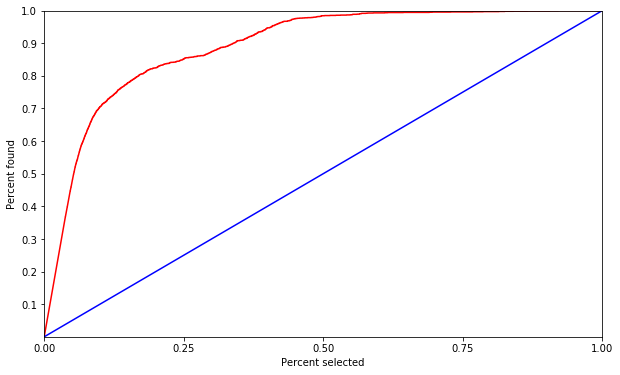

In [168]:
plot_curve(results)

In [169]:
from sklearn.feature_extraction.text import CountVectorizer

def word_probabilities(col, pipeline=pl, min_df=.01):
    words_dict = {}
    bow_transformer = CountVectorizer(min_df=min_df, ngram_range=(1,3))
    bow_transformer.fit(col)

    for word in bow_transformer.vocabulary_.keys():
        prob = pipeline.predict_proba([word])[0][1]
        words_dict[word] = prob
        
    df = pd.DataFrame([words_dict]).T
    df.columns = ['probability']
    df = df.sort_values('probability', ascending=False)
    
    return df

In [170]:
# Generate word list
words = word_probabilities(train['comment_text'], model_binary)

words

,probability
fucking,1.000000
fuck,0.999993
big,0.475875
whatever,0.370947
hey,0.267224
dont,0.243542
oh,0.220517
simple,0.138186
love,0.136681
admin,0.126254


In [15]:
# Don't un-comment this unless you want to see the worst of humanity :)

# train['pred'] = pred_proba
# train.sort_values('pred', ascending=False)

# TODO:
    
- Deep learning